# Optimization

<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Setup</h1></u>
</div>

In the finite-dimensional unconstrained optimization problem, one is given a function $f : R^n \mapsto R$ and asked to find an $x^∗$ such that $f (x^∗) \geq f(x)$ for all $x$. We call $f$ the objective function and $x^∗$ , if it exists, the global maximum of $f$. We focus on maximization - to solve a minimization problem, simply maximize the negative of the objective.


We say that $x^∗ \in R^n$ is a ...

* strict global maximum of $f$ if $f(x^∗) > f (x)$ for all $x\neq x^∗$.
* local maximum of $f$ if $f(x^∗) \geq f(x)$ for all $x$ in some neighborhood of $x^∗$.
* strict local maximum of $f$ if $f(x^∗) > f(x)$ for all $x\neq x^∗$ in some neighborhood of $x^∗$.


Let $f: R^n \mapsto R$ be twice continously differentiable.

* **First Order Necessary Conditions:** If $x^*$ is a local maximum of $f$, then $f^{\prime}(x^*) = 0$. 
* **Second Order Necessary Condition:** If $x^∗$ is a local maximum of $f$, then $f^{\prime\prime}(x^*)$ is negative semidefinite. 

We say $x$ is a critical point of $f$ if it satisfies the first-order necessary condition.

* **Sufficient Condition:** If $f^\prime (x^∗) = 0$ and $f^{\prime\prime}(x^∗)$ is negative definite, then $x^∗$ is a strict local maximum of $f$.
* **Local-Global Theorem:** If $f$ is concave, and $x^∗$ is a local maximum of $f$, then $x^∗$ is a global maximum of $f$.

Unconstrained optimization problems are ubiquitous in economics:
* Government maximizes social welfare
* Competitive equilibrium maximizes total surplus
* Ordinary least squares estimator minimizes sum of squares
* Maximum likelihood estimator maximizes likelihood function

In [65]:
import scipy as sp
from scipy import optimize
import pandas as pd
import numpy as np
import temfpy
import matplotlib.pyplot as plt

from optimization_algorithms import golden_search
from optimization_plots import plot_golden_search_problem

from optimization_problems import get_nelder_mead_problem
from optimization_algorithms import golden_search

<div class="alert alert-block alert-info">
    <u><h2>Rosebrock  Function</h2></u>
</div>

We will use the famous Rosenbrock function to benchmark the different optimization approaches throughout this chapter.


\begin{align*}
f(x) = \sum^{d-1}_{i = 1} \left[100(x_{i+1}-x_i^2)^2 + (1-x_i^2) \right]
\end{align*}

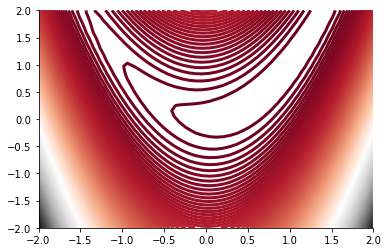

In [99]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 40)

X, Y = np.meshgrid(x, y)


def rosenbrock_2d(x, y):
    return -100 * (y - x ** 2) ** 2 - (1 - x) ** 2


Z = f(X, Y)

plt.contour(X, Y, Z, 200, cmap="RdGy")

<div class="alert alert-block alert-info">
    <u><h2>Derivative-Free Methods</h2></u>
</div>

As was the case with univariate rootfinding, optimization algorithms exist that will place progressively smaller brackets around a local maximum of a univariate function. Such methods are relatively slow, but they do not require the evaluation of function derivatives and are guaranteed to find a local optimum to a prescribed tolerance in a known number of steps.

### Golden search 

In [39]:
??golden_search

Signature: golden_search(f, a, b, tol=1e-05)
Docstring: <no docstring>
Source:   
def golden_search(f, a, b, tol=1e-5):
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    x1 = a + alpha1 * (b - a)
    f1 = f(x1)
    x2 = a + alpha2 * (b - a)
    f2 = f(x2)
    d = alpha1 * alpha2 * (b - a)

    while d > tol:
        d = d * alpha2
        if f2 < f1:
            x2 = x1
            x1 = x1 - d
            f2 = f1
            f1 = f(x1)
        else:
            x1 = x2
            x2 = x2 + d
            f1 = f2
            f2 = f(x2)

        if f2 > f1:
            x = x2
        else:
            x = x1

    return x
File:      ~/external-storage/ownCloud/office/OpenSourceEconomics/teaching/scientific-computing/course/lectures/optimization/optimization_algorithms.py
Type:      function


We want to compute the maximum of the following function on the interval $[0, 3]$.

\begin{align*}
f(x) = x \cos (x^2)
\end{align*}

In [40]:
def golden_search_problem(x):
    return x * np.cos(x ** 2)

We start with a visualization.

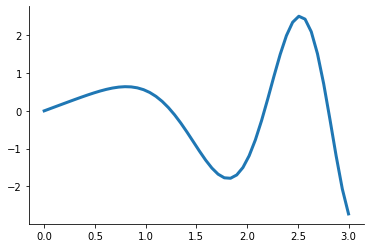

In [41]:
plot_golden_search_problem(golden_search_problem)

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>Whare is a potential problem?</li>
    </ul> 
</div>

In [42]:
x = golden_search(golden_search_problem, 0, 3)
print(f"Result from our algorithm is {x:5.3f}.")

Result from our algorithm is 0.808.


The golden search method is guaranteed to find the global maximum when the function is concave. However, as the present example makes clear, this guarantee does not hold when the optimand is not concave.

### Nelder-Mead

A derivative-free optimization method for multivariate functions is the Nelder-Mead algorithm. The algorithm begins by evaluating the objective function at $n + 1$ points. These $n + 1$ points form a so-called simplex in the n-dimensional decision space. This algorithm is most easily visualized when $x$ is two-dimensional, in which case a simplex is a triangle. 

<img src="material/fig-nelder-mead-iteration.png" width=500 height=500 />


In [100]:
x0 = [1.0, 0.0]
rslt = optimize.minimize(get_nelder_mead_problem, x0, options={"return_all": True})
np.testing.assert_almost_equal(get_nelder_mead_problem(rslt["x"]), 0.0)

The Nelder-Mead algorithm is simple but slow and unreliable.

<img src="material/fig-nelder-mead-banana.png" width=400 height=400 />

<div class="alert alert-block alert-info">
    <u><h2>Derivative-based Methods</h2></u>
</div>


### Newton-Raphson Method

The Newton-Raphson method maximizes an objective $f$ using successive quadratic approximations. Given the $k$-th iterate $x_k$, the subsequent iterate $x_{k+1}$ is computed by maximizing the quadratic approximation to $f$ about $x_k$:

\begin{align*}
f(x) \approx f(x_k) + f^\prime(x_k) (x - x_k ) + \frac{1}{2} (x − x_k )^\prime f^{\prime\prime}(x_k) (x - x_k).
\end{align*}

Solving the first-order condition

\begin{align*}
    f^\prime(x_k ) + f^{\prime\prime}(x_k)(x - x_k ) = 0
\end{align*}

yields the iteration rule

\begin{align*}
x_{k+1} = x_k - [f ′′ (x_k)]^{-1} f^\prime(x_k)
\end{align*}

The Newton-Raphson method is identical to using Newton’s method to compute the root of the gradient of the objective. In theory, it will converge if the initial value is “close” to a critical point of $f$ at which the Hessian is non-singular. In practice, it will diverge if the initial value is “far” from a critical point or the Hessian becomes ill-conditioned. Moreover, it may converge to a critical point that is not a local maximum, so the second-order necessary condition should always be checked. Newton-Raphson can be robust to the starting value if $f$ is globally concave, but sensitive otherwise.

Newton-Raphson has two drawbacks:

* it requires computation of both the first and second derivatives. 
* it may not be possible to increase the objective in the direction of the Newton step ... this is guaranteed only if $f^{\prime\prime} (x_k)$ is negative definite. 


### Quasi-Newton Method

In analogy with the Newton-Raphson method, quasi-Newton methods update iterates in the direction of the vector

\begin{align*}
d_k = -A_k f^\prime(x_k)
\end{align*}

where $A_k$ is an approximation to the inverse Hessian of $f$ at the $k$th iterate $x_k$. The vector $d_k$ is called the Newton or quasi-Newton step. Just as with rootfinding problems, it is not always best to take a full Newton step at each iteration. Efficient quasi-Newton methods shorten or lengthen the Newton step to increase gains in the objective. This is accomplished by performing a line search in which the Newton step is re-scaled by a factor $s > 0$ that maximizes or nearly maximizes $f(x_k + s_k d_k )$. This is accomplished by performing a line search in which
the Newton step is re-scaled by a factor $s > 0$ that maximizes or nearly maximizes $f(x_k + s d_k)$.

Given the computed scaling factor $s_k$, one updates the iterate as follows:

\begin{align*}
x_{k+1} = x_k + s_k d_k.
\end{align*}

In practice, a thorough line search is not necessary. A number of different line search methods are used in practice.

Quasi-Newton algorithms differ in how the inverse Hessian approximation $A_k$ is constructed and updated. Efficient algorithms use negative definite inverse Hessian approximations, guaranteeing the objective can be increased in the direction of the Newton step. Efficient quasi-Newton algorithms also employ updating rules that do not require computing second derivatives.

* **Method of steepest ascent**

The simplest quasi-Newton method sets $A_k = −I$, where $I$ is the identity matrix, leading to a Newton step that is identical to the gradient of the objective: 

\begin{align*}
d_k = f^\prime(x_k).
\end{align*}

This is called the method of steepest ascent because the gradient, to a first order, promises the greatest increase in $f$.